# This notebook trains a L1 regularized Logistic Regression (LR) multilabel classifier to classify genes by their functional category. 
# The classifiers ability to predict genes in particular functional categories is then visualized and reviewed through ROC curves and AUROC analysis as well as heat maps generated from confusion matrices. Handling class imbalance with SMOTE and balanced weights is also analyzed
# This process is also performed with transformed LFC data using UMAP embeddings

## Imports

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
from tqdm import tqdm
import pathlib
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MultiLabelBinarizer, normalize, label_binarize
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, roc_curve, cohen_kappa_score, roc_auc_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import matplotlib.pyplot as plt
import warnings
import os
from collections import defaultdict
from imblearn.over_sampling import SMOTE

## Functions

### Trains the classifier and performs evaluation of accuracy through confusion matricies

In [2]:
def lasso_confusion(mat, cols, C, norm_method, name, figsize=(7, 7)):
    X = mat[cols].values
    y = mat['Functional_Category'].values
    n_classes = mat['Functional_Category'].nunique()
    accuracy = []
    n_splits = 3
    confusion = np.zeros((n_classes, n_classes))
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    y_true_all = []
    y_pred_all = []
    y_score_all = np.zeros((len(y), n_classes))

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        if norm_method == 'SMOTE':
            X_train, y_train = SMOTE().fit_resample(X_train, y_train)
            clf = LogisticRegression(
                penalty='l1', solver='liblinear', multi_class='ovr', C=C, random_state=42)
        elif norm_method == 'bal_weights':
            clf = LogisticRegression(
                penalty='l1', solver='liblinear', multi_class='ovr', C=C, class_weight='balanced', random_state=42)
        elif norm_method == None:
            clf = LogisticRegression(
                penalty='l1', solver='liblinear', multi_class='ovr', C=C, random_state=42)
        clf.fit(X_train, y_train)
        y_hat = clf.predict(X_test)
        y_score = clf.decision_function(X_test)
        
        y_true_all.extend(y_test)
        y_pred_all.extend(y_hat)
        y_score_all[test_index] = y_score

        confusion += confusion_matrix(y_test, y_hat)
        accuracy.append(accuracy_score(y_test, y_hat))
    
    confusion = normalize(confusion, axis=1, norm='l1')
    print(accuracy)

    # Create confusion matrix
    col_names = ['PE/PPE', 'cell wall and\ncell processes', 'information pathways', 'insertion seqs\nand phages',
                 'intermediary metabolism\nand respiration', 'lipid metabolism', 'regulatory proteins', 'virulence, detoxification,\nadaptation']
    confusion = pd.DataFrame(
        confusion, columns=col_names, index=col_names)
    plt.figure(figsize=figsize)
    rc = {'xtick.labelsize': 14, 'ytick.labelsize': 14, 'axes.labelsize': 14}
    sns.set(rc=rc)
    heat = sns.heatmap(confusion, annot=True, linewidths=.1,
                       fmt='1.2f', square=True)
    heat.set(xlabel='PREDICTED CLASS', ylabel='TRUE CLASS', title=name)

    # Compute and print additional metrics
    classes = np.unique(y)
    metrics = compute_metrics(np.array(y_true_all), np.array(y_pred_all), y_score_all, classes)
    print_metrics(metrics, "Logistic Regression with L1 Regularization")

    return None

### Trains the classifier and outputs model coeffcients

In [3]:
def lasso_coefs(mat, cols, C, norm_method):
    X = mat[cols].values
    y = mat['Functional_Category'].values
    if norm_method == 'SMOTE':
        X, y = SMOTE().fit_resample(X, y)
        clf = LogisticRegression(
            penalty='l1', solver='liblinear', multi_class='ovr', C=C, random_state=42)
    if norm_method == 'bal_weights':
        clf = LogisticRegression(
            penalty='l1', solver='liblinear', multi_class='ovr', C=C, class_weight='balanced', random_state=42)
    clf.fit(X, y)
    coefs = clf.coef_
    coefs = np.transpose(coefs)
    coefs = pd.DataFrame(coefs, columns=clf.classes_, index=cols)

    # Compute metrics
    y_pred = clf.predict(X)
    y_score = clf.decision_function(X)
    classes = np.unique(y)
    metrics = compute_metrics(y, y_pred, y_score, classes)
    print_metrics(metrics, "Logistic Regression Coefficients")

    return coefs

### Trains the classifier over varying regularization strengths

In [4]:
def lasso_vanilla(mat, cols, Cs):
    X = mat[cols].values
    y = mat['Functional_Category'].values
    accuracy = {}
    metrics_dict = {}
    for C in Cs:
        skf = StratifiedKFold(n_splits=3, shuffle=True)
        accuracy_per_fold = []
        y_true_all = []
        y_pred_all = []
        y_score_all = np.zeros((len(y), len(np.unique(y))))

        for train_index, test_index in skf.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            X_train, y_train = SMOTE().fit_resample(X_train, y_train)
            clf = LogisticRegression(
                penalty='l1', solver='liblinear', multi_class='ovr', C=C)
            clf.fit(X_train, y_train)
            y_hat = clf.predict(X_test)
            y_score = clf.decision_function(X_test)
            
            y_true_all.extend(y_test)
            y_pred_all.extend(y_hat)
            y_score_all[test_index] = y_score

            accuracy_per_fold.append(balanced_accuracy_score(y_test, y_hat))

        accuracy[C] = sum(accuracy_per_fold)/len(accuracy_per_fold)

        # Compute metrics for this C value
        classes = np.unique(y)
        metrics = compute_metrics(np.array(y_true_all), np.array(y_pred_all), y_score_all, classes)
        metrics_dict[C] = metrics

    print(accuracy)

    for C, metrics in metrics_dict.items():
        print_metrics(metrics, f"Logistic Regression Vanilla C={C}")

    # return accuracy

### This function generates accuracy/precision metrics for the classifier

In [5]:
def compute_metrics(y_true, y_pred, y_score, classes):
    # Macro-averaged F1 Score
    f1_macro = f1_score(y_true, y_pred, average='macro')
    
    # Weighted F1 Score
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    
    # Cohen's Kappa
    kappa = cohen_kappa_score(y_true, y_pred)
    
    # Macro-averaged AUROC
    y_true_bin = label_binarize(y_true, classes=classes)
    y_pred_bin = label_binarize(y_pred, classes=classes)
    macro_roc_auc = roc_auc_score(y_true_bin, y_score, average='macro', multi_class='ovr')
    
    return {
        'F1 Macro': f1_macro,
        'F1 Weighted': f1_weighted,
        'Cohen\'s Kappa': kappa,
        'Macro AUROC': macro_roc_auc
    }

def print_metrics(metrics, model_name):
    print(f"Metrics for {model_name}:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")
    print()


## With log2FC and q-val- mycobrowser

In [6]:
#%reset -f

In [7]:
lfc_mb_filt = pd.read_csv(
    '../../../data/standardized_data/cleaned_ML/lfc_mb_filt_07_22_24.csv')
qval_mb_filt = pd.read_csv(
    '../../../data/standardized_data/cleaned_ML/qval_mb_filt_07_22_24.csv')

In [8]:
# replaced values of qval lower than 0.05 with 0.05. Then divided log2FC by qval^beta
def lasso_inv_p(betas, Cs, lfc, qval, value_cols):
    X = lfc[value_cols].values
    y = lfc['Functional_Category'].values

    qval = qval[value_cols].apply(lambda x: np.where(x < 0.05, 0.05, x))
    qval = qval[value_cols].values
    
    accuracy = pd.DataFrame(index=betas, columns=Cs, dtype='float')
    for b in betas:
        X = X/np.power(qval, b)
        for C in Cs:
            # print(b)
            skf = StratifiedKFold(n_splits=3, shuffle=True)
            accuracy_per_fold = []
            for train_index, test_index in skf.split(X, y):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]
                X_train, y_train = SMOTE().fit_resample(X_train, y_train)
                clf = LogisticRegression(
                    penalty='l1', solver='liblinear', multi_class='ovr', C=C)
                clf.fit(X_train, y_train)
                y_hat = clf.predict(X_test)
                accuracy_per_fold.append(accuracy_score(y_test, y_hat))
            accuracy.loc[b, C] = sum(accuracy_per_fold)/len(accuracy_per_fold)
    plt.figure()
    heat = sns.heatmap(accuracy, annot=True, linewidths=.1, fmt='1.2f')
    heat.set(xlabel='Cs', ylabel='betas',
             title='Accuracy with LR on log2FC w pval')
    return None

In [9]:
betas = [0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4]
Cs = [0.005, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100]

In [10]:
(lfc_mb_filt.columns == qval_mb_filt.columns).all() 

False

In [11]:
# Reorder the columns in qval_mb_filt to match lfc_mb_filt
qval_mb_filt = qval_mb_filt[lfc_mb_filt.columns]
(lfc_mb_filt.columns == qval_mb_filt.columns).all() 

True

In [12]:
qval_mb_filt.head()

,Rv_ID,PE35_KO_vs_mbio_H37Rv,PPE68_KO_vs_mbio_H37Rv,Rv0950c_KO_vs_CB_WT,Rv0954_KO_vs_RJ_WT,Rv1096_KO_vs_CB_WT,Rv3005c_KO_day32_vs_dejesus_H37Rv_day32,Rv3594_KO_vs_Rubin_FLUTE_WT,Rv3684_KO_vs_CB_WT,Rv3717_KO_vs_Rubin_FLUTE_WT,...,BXD73_vs_in_vitro_H37Rv,BXD73b_vs_in_vitro_H37Rv,BXD77_vs_in_vitro_H37Rv,BXD79_vs_in_vitro_H37Rv,BXD9_vs_in_vitro_H37Rv,BXD90_vs_in_vitro_H37Rv,BXD93_vs_in_vitro_H37Rv,C57BL.6J_vs_in_vitro_H37Rv,DBA.2J_vs_in_vitro_H37Rv,Functional_Category
0,Rv0001,1.0,1.0,1.0,1.00000,1.0,0.73174,1.0,1.0,1.0,...,1.00000,1.00000,1.0,1.000,1.00000,1.0,1.00000,1.0,1.00000,information pathways
1,Rv0002,1.0,1.0,1.0,1.00000,1.0,1.00000,1.0,1.0,1.0,...,1.00000,1.00000,1.0,1.000,1.00000,1.0,1.00000,1.0,1.00000,information pathways
2,Rv0003,1.0,1.0,1.0,0.43844,1.0,0.47324,1.0,1.0,1.0,...,0.18516,1.00000,1.0,0.931,1.00000,1.0,1.00000,1.0,0.91886,information pathways
3,Rv0005,1.0,1.0,1.0,1.00000,1.0,0.62111,1.0,1.0,1.0,...,1.00000,0.98550,1.0,1.000,1.00000,1.0,1.00000,1.0,1.00000,information pathways
4,Rv0006,1.0,1.0,1.0,1.00000,1.0,1.00000,1.0,1.0,1.0,...,1.00000,0.97824,1.0,1.000,0.97593,1.0,0.97811,1.0,0.73103,information pathways


In [13]:
lfc_mb_filt.head()

,Rv_ID,PE35_KO_vs_mbio_H37Rv,PPE68_KO_vs_mbio_H37Rv,Rv0950c_KO_vs_CB_WT,Rv0954_KO_vs_RJ_WT,Rv1096_KO_vs_CB_WT,Rv3005c_KO_day32_vs_dejesus_H37Rv_day32,Rv3594_KO_vs_Rubin_FLUTE_WT,Rv3684_KO_vs_CB_WT,Rv3717_KO_vs_Rubin_FLUTE_WT,...,BXD73_vs_in_vitro_H37Rv,BXD73b_vs_in_vitro_H37Rv,BXD77_vs_in_vitro_H37Rv,BXD79_vs_in_vitro_H37Rv,BXD9_vs_in_vitro_H37Rv,BXD90_vs_in_vitro_H37Rv,BXD93_vs_in_vitro_H37Rv,C57BL.6J_vs_in_vitro_H37Rv,DBA.2J_vs_in_vitro_H37Rv,Functional_Category
0,Rv0001,-0.41,0.01,0.00,0.00,0.00,3.12,-0.06,0.00,-0.06,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,information pathways
1,Rv0002,3.28,2.38,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.48,0.00,0.00,0.00,information pathways
2,Rv0003,-0.03,-0.08,0.03,-1.20,0.39,3.83,0.31,0.17,-0.62,...,0.97,-0.19,0.05,0.59,0.04,0.13,0.33,0.43,0.32,information pathways
3,Rv0005,-0.22,0.14,0.13,-0.08,0.27,-2.38,0.70,-0.71,-0.37,...,-0.30,-1.79,-1.34,-0.33,-1.84,-0.30,0.71,-0.27,-0.02,information pathways
4,Rv0006,0.53,0.37,-1.21,1.66,0.25,1.18,3.31,-0.10,-0.12,...,-1.10,-0.95,0.33,-0.20,-1.32,-0.35,-0.88,1.49,-1.31,information pathways


In [14]:
value_cols = [col for col in lfc_mb_filt.columns if col not in [
    'Rv_ID', 'Functional_Category']]

In [15]:
def lasso_inv_p(betas, Cs, lfc, qval, value_cols):
    X = lfc[value_cols].values
    y = lfc['Functional_Category'].values
    qval = qval[value_cols].apply(lambda x: np.where(x < 0.05, 0.05, x))
    qval = qval[value_cols].values
    accuracy = pd.DataFrame(index=betas, columns=Cs, dtype='float')
    for b in betas:
        print(f"Processing beta: {b}")
        X_mod = X / np.power(qval, b)
        for C in Cs:
            print(f"Processing C: {C}")
            skf = StratifiedKFold(n_splits=3, shuffle=True)
            accuracy_per_fold = []
            for train_index, test_index in skf.split(X_mod, y):
                X_train, X_test = X_mod[train_index], X_mod[test_index]
                y_train, y_test = y[train_index], y[test_index]
                X_train, y_train = SMOTE().fit_resample(X_train, y_train)
                clf = LogisticRegression(
                    penalty='l1', solver='liblinear', multi_class='ovr', C=C)
                clf.fit(X_train, y_train)
                y_hat = clf.predict(X_test)
                accuracy_per_fold.append(accuracy_score(y_test, y_hat))
            accuracy.loc[b, C] = sum(accuracy_per_fold) / len(accuracy_per_fold)
    plt.figure()
    heat = sns.heatmap(accuracy, annot=True, linewidths=.1, fmt='1.2f')
    heat.set(xlabel='Cs', ylabel='betas', title='Accuracy with LR on log2FC w pval')
    return None


Processing beta: 0
Processing C: 0.005
Processing C: 0.05
Processing C: 0.1
Processing C: 0.5
Processing C: 1
Processing C: 5
Processing C: 10
Processing C: 50
Processing C: 100
Processing beta: 0.02
Processing C: 0.005
Processing C: 0.05
Processing C: 0.1
Processing C: 0.5
Processing C: 1
Processing C: 5
Processing C: 10
Processing C: 50
Processing C: 100
Processing beta: 0.05
Processing C: 0.005
Processing C: 0.05
Processing C: 0.1
Processing C: 0.5
Processing C: 1
Processing C: 5
Processing C: 10
Processing C: 50
Processing C: 100
Processing beta: 0.1
Processing C: 0.005
Processing C: 0.05
Processing C: 0.1
Processing C: 0.5
Processing C: 1
Processing C: 5
Processing C: 10
Processing C: 50
Processing C: 100
Processing beta: 0.2
Processing C: 0.005
Processing C: 0.05
Processing C: 0.1
Processing C: 0.5
Processing C: 1
Processing C: 5
Processing C: 10
Processing C: 50
Processing C: 100
Processing beta: 0.3
Processing C: 0.005
Processing C: 0.05
Processing C: 0.1
Processing C: 0.5
Proc

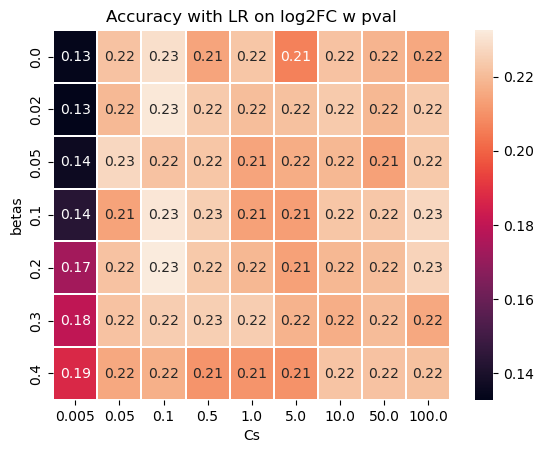

In [16]:
lasso_inv_p(betas, Cs, lfc_mb_filt, qval_mb_filt, value_cols)

In [17]:
def lasso_min_p(lfc, qval, C, value_cols):
    X = lfc[value_cols].values
    y = lfc['Functional_Category'].values
    # replace values lower than 0.05 with 0.05
    qval = qval[value_cols].apply(lambda x: np.where(x < 0.05, 0.05, x))
    qval = qval[value_cols].values
    # print(X,y)
    accuracy = []
    X = X*(1-qval)
    skf = StratifiedKFold(n_splits=3, shuffle=True)
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        X_train, y_train = SMOTE().fit_resample(X_train, y_train)
        clf = LogisticRegression(
            penalty='l1', solver='liblinear', multi_class='ovr', C=C)
        clf.fit(X_train, y_train)
        y_hat = clf.predict(X_test)
        accuracy.append(accuracy_score(y_test, y_hat))
    print(accuracy)
    # return accuracy

In [19]:
lasso_min_p(lfc_mb_filt, qval_mb_filt, 10, value_cols)

[0.2083758937691522, 0.21041879468845762, 0.21144024514811033]


## With lfc only - mycobrowser

In [20]:
#%reset -f

In [21]:
lfc_mb_filt = pd.read_csv(
    '../../../data/standardized_data/cleaned_ML/lfc_mb_filt_07_22_24.csv')

In [22]:
value_cols = [col for col in lfc_mb_filt.columns if col not in [
    'Rv_ID', 'Functional_Category']]

### Function implements the multilabel classifier equipped with precision metrics and ROC curves

#### Uses XGBoost classifier

In [23]:
warnings.filterwarnings(action='ignore', category=UserWarning, module='xgboost')

def lr_w_lasso_multilabel(mat, cols, C, norm_method, classifier, name, threshold=0.5, n_splits=5, figsize=(7, 7), save_path=None):
    X = mat[cols].values
    y = mat['Functional_Category'].values
    n_classes = mat['Functional_Category'].nunique()
    accuracy = []
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    mlb = MultiLabelBinarizer()
    y_multi = mlb.fit_transform([[label] for label in y])
    
    y_true_all = []
    y_pred_all = []
    y_score_all = []
    
    with tqdm(total=n_splits, desc="Cross-validation") as pbar:
        for train_index, test_index in skf.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y_multi[train_index], y_multi[test_index]
            
            if norm_method == 'SMOTE':
                X_train, y_train = SMOTE().fit_resample(X_train, y_train)
            
            if classifier == 'lr':
                base_clf = LogisticRegression(penalty='l1', solver='liblinear', C=C, random_state=42)
            elif classifier == 'rf':
                base_clf = RandomForestClassifier(n_estimators=100, random_state=42)
            elif classifier == 'xgb':
                base_clf = xgb.XGBClassifier(eval_metric='logloss', random_state=42)
                
            clf = OneVsRestClassifier(base_clf)
            clf.fit(X_train, y_train)
            
            y_score = clf.predict_proba(X_test)
            y_hat = (y_score >= threshold).astype(int)
            
            y_true_all.extend(y_test)
            y_pred_all.extend(y_hat)
            y_score_all.extend(y_score)
            
            accuracy.append(accuracy_score(y_test, y_hat))
            pbar.update(1)
    
    y_true_all = np.array(y_true_all)
    y_pred_all = np.array(y_pred_all)
    y_score_all = np.array(y_score_all)
    
    # Per-class metrics
    col_names = ['PE/PPE', 'cell wall and\ncell processes', 'information pathways', 'insertion seqs\nand phages',
                 'intermediary metabolism\nand respiration', 'lipid metabolism', 'regulatory proteins', 'virulence, detoxification,\nadaptation']
    
    precisions = []
    recalls = []
    f1_scores = []
    roc_aucs = []
    
    print(f"\nPer-class metrics for {name}:")
    for i, class_name in enumerate(col_names):
        precision = precision_score(y_true_all[:, i], y_pred_all[:, i])
        recall = recall_score(y_true_all[:, i], y_pred_all[:, i])
        f1 = f1_score(y_true_all[:, i], y_pred_all[:, i])
        roc_auc = roc_auc_score(y_true_all[:, i], y_score_all[:, i])
        
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)
        roc_aucs.append(roc_auc)
        
        print(f"\nClass {i} - {class_name}:")
        print(f"  Precision: {precision:.3f}")
        print(f"  Recall: {recall:.3f}")
        print(f"  F1-score: {f1:.3f}")
        print(f"  ROC AUC: {roc_auc:.3f}")
    
    # Global metrics (macro average)
    macro_precision = np.mean(precisions)
    macro_recall = np.mean(recalls)
    macro_f1 = np.mean(f1_scores)
    macro_roc_auc = np.mean(roc_aucs)
    
    print(f"\nGlobal Metrics (Macro Average) for {name}:")
    print(f"  Precision: {macro_precision:.3f}")
    print(f"  Recall: {macro_recall:.3f}")
    print(f"  F1-score: {macro_f1:.3f}")
    print(f"  ROC AUC: {macro_roc_auc:.3f}")
    
    # Plot ROC curves with white background and no grid
    plt.figure(figsize=(12, 10))
    for i, class_name in enumerate(col_names):
        fpr, tpr, _ = roc_curve(y_true_all[:, i], y_score_all[:, i])
        plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_aucs[i]:.2f})')  
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=24)
    plt.ylabel('True Positive Rate', fontsize=24)
    plt.legend(loc="lower right", fontsize=18)
    plt.gca().set_facecolor('white')  # Set the background color to white
    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_edgecolor('black')
        spine.set_linewidth(1)
    ax.tick_params(axis='y', which='both', left=True, right=False)  
    plt.grid(False)  
    plt.tight_layout()  
    
    save_dir = '/Users/amandaspencer/Documents/repos/mtb_tn_db/figures'
    save_path = os.path.join(save_dir, f"{name}_ROC_curve.png")
    plt.savefig(save_path, format='png', dpi=300)
  
    plt.show()
    
    return None

Cross-validation: 100%|███████████████████████████| 5/5 [01:27<00:00, 17.52s/it]



Per-class metrics for Accuracy_log2FC_XGB_Multilabel_SMOTE_C=10:

Class 0 - PE/PPE:
  Precision: 0.923
  Recall: 0.296
  F1-score: 0.449
  ROC AUC: 0.860

Class 1 - cell wall and
cell processes:
  Precision: 0.500
  Recall: 0.105
  F1-score: 0.174
  ROC AUC: 0.609

Class 2 - information pathways:
  Precision: 0.296
  Recall: 0.087
  F1-score: 0.134
  ROC AUC: 0.688

Class 3 - insertion seqs
and phages:
  Precision: 0.887
  Recall: 0.331
  F1-score: 0.482
  ROC AUC: 0.817

Class 4 - intermediary metabolism
and respiration:
  Precision: 0.504
  Recall: 0.138
  F1-score: 0.217
  ROC AUC: 0.619

Class 5 - lipid metabolism:
  Precision: 0.643
  Recall: 0.067
  F1-score: 0.121
  ROC AUC: 0.576

Class 6 - regulatory proteins:
  Precision: 0.312
  Recall: 0.025
  F1-score: 0.047
  ROC AUC: 0.607

Class 7 - virulence, detoxification,
adaptation:
  Precision: 0.409
  Recall: 0.041
  F1-score: 0.074
  ROC AUC: 0.627

Global Metrics (Macro Average) for Accuracy_log2FC_XGB_Multilabel_SMOTE_C=10:
 

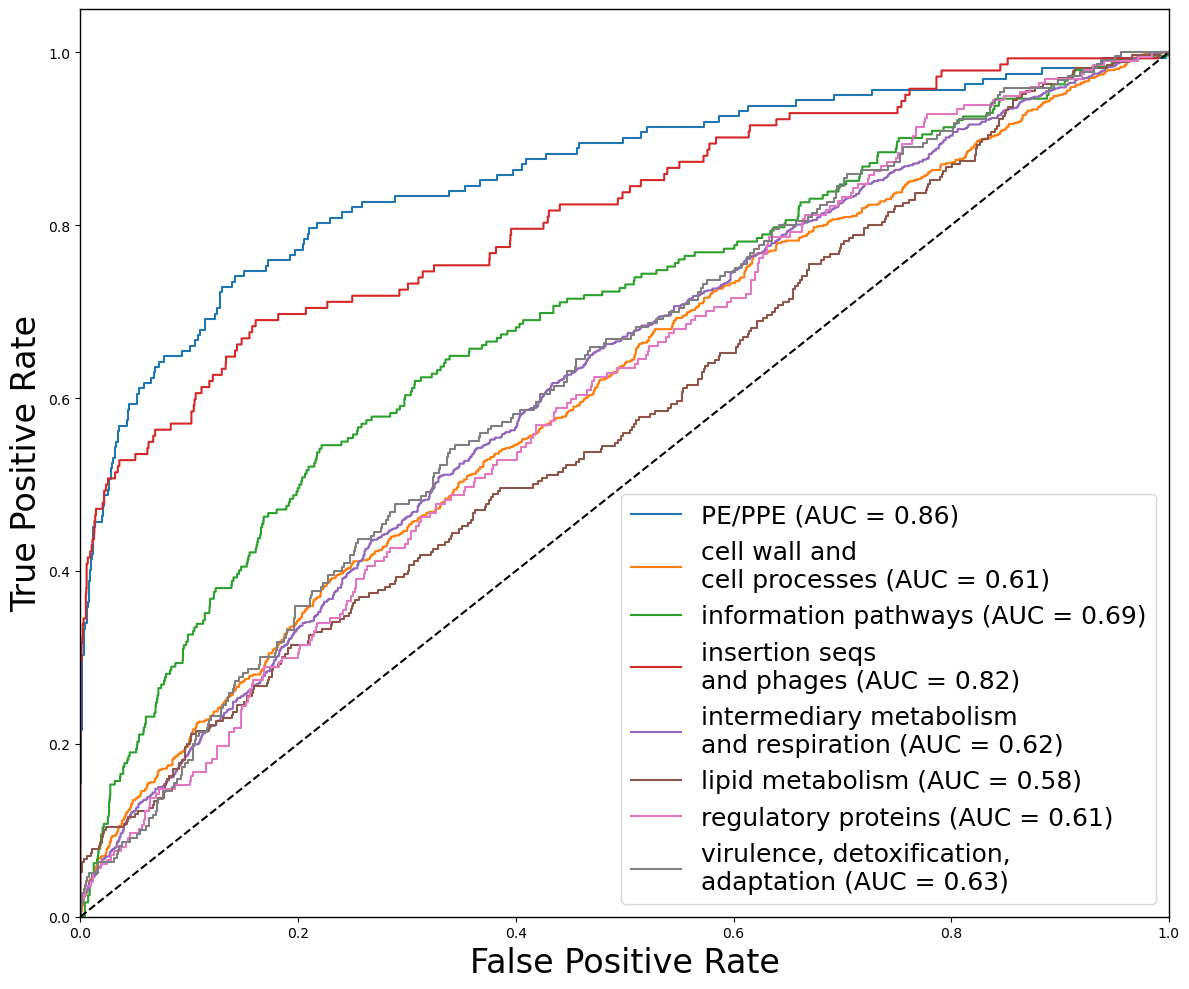

In [24]:
value_cols = [col for col in lfc_mb_filt.columns if col not in ['Rv_ID', 'Functional_Category']] 

lr_w_lasso_multilabel(lfc_mb_filt, value_cols, C=10, n_splits=5,
                norm_method='SMOTE', classifier='xgb', name='Accuracy_log2FC_XGB_Multilabel_SMOTE_C=10', save_path= 'Accuracy_log2FC_XGB_Multilabel_ROC_curve.png')

In [25]:
mlb = MultiLabelBinarizer()
y_multi = mlb.fit_transform([[label] for label in lfc_mb_filt['Functional_Category']])


category_counts = pd.DataFrame(y_multi, columns=mlb.classes_).sum()

print("Count of genes in each functional category:")
print(category_counts)

multi_category_counts = (y_multi.sum(axis=1) > 1).sum()
none_category_counts = (y_multi.sum(axis=1) == 0).sum()

print(f"\nNumber of genes sorted into multiple categories: {multi_category_counts}")
print(f"Number of genes not sorted into any category: {none_category_counts}")


Count of genes in each functional category:
PE/PPE                                     162
cell wall and cell processes               771
information pathways                       242
insertion seqs and phages                  142
intermediary metabolism and respiration    933
lipid metabolism                           270
regulatory proteins                        197
virulence, detoxification, adaptation      220
dtype: int64

Number of genes sorted into multiple categories: 0
Number of genes not sorted into any category: 0


#### Uses LR classifier

Cross-validation: 100%|███████████████████████████| 5/5 [01:39<00:00, 19.92s/it]



Per-class metrics for Accuracy_log2FC_LR_Multilabel_SMOTE_C=10:

Class 0 - PE/PPE:
  Precision: 0.245
  Recall: 0.420
  F1-score: 0.310
  ROC AUC: 0.802

Class 1 - cell wall and
cell processes:
  Precision: 0.427
  Recall: 0.083
  F1-score: 0.139
  ROC AUC: 0.569

Class 2 - information pathways:
  Precision: 0.183
  Recall: 0.157
  F1-score: 0.169
  ROC AUC: 0.638

Class 3 - insertion seqs
and phages:
  Precision: 0.267
  Recall: 0.415
  F1-score: 0.325
  ROC AUC: 0.774

Class 4 - intermediary metabolism
and respiration:
  Precision: 0.555
  Recall: 0.076
  F1-score: 0.134
  ROC AUC: 0.591

Class 5 - lipid metabolism:
  Precision: 0.164
  Recall: 0.104
  F1-score: 0.127
  ROC AUC: 0.573

Class 6 - regulatory proteins:
  Precision: 0.128
  Recall: 0.117
  F1-score: 0.122
  ROC AUC: 0.553

Class 7 - virulence, detoxification,
adaptation:
  Precision: 0.152
  Recall: 0.141
  F1-score: 0.146
  ROC AUC: 0.583

Global Metrics (Macro Average) for Accuracy_log2FC_LR_Multilabel_SMOTE_C=10:
  P

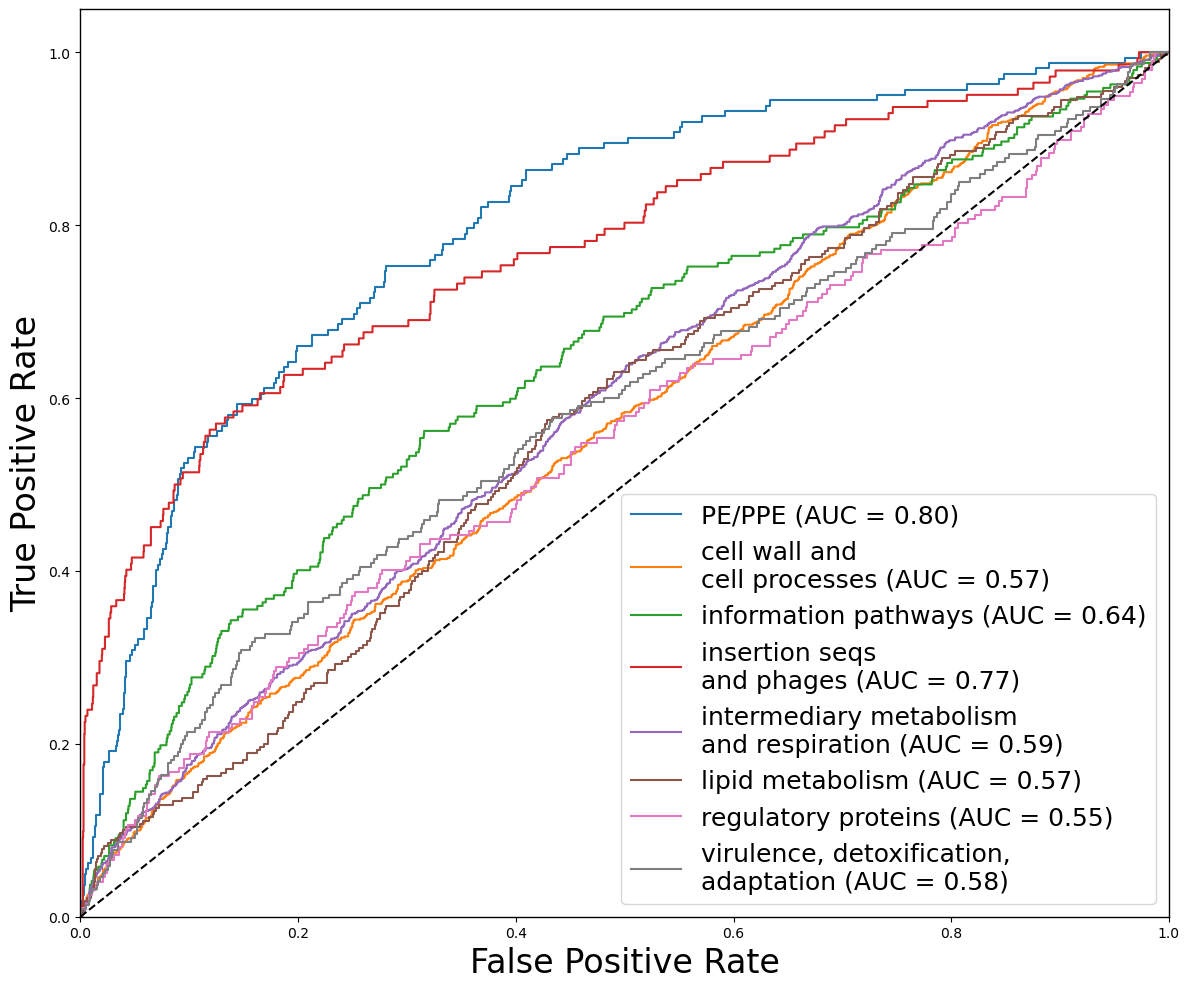

In [26]:
value_cols = [col for col in lfc_mb_filt.columns if col not in ['Rv_ID', 'Functional_Category']] 

lr_w_lasso_multilabel(lfc_mb_filt, value_cols, C=10, n_splits=5,
                norm_method='SMOTE', classifier='lr', name='Accuracy_log2FC_LR_Multilabel_SMOTE_C=10')

#### Uses RF classifier

Cross-validation: 100%|███████████████████████████| 5/5 [06:19<00:00, 75.89s/it]



Per-class metrics for Accuracy_log2FC_RF_Multilabel_SMOTE_C=10:

Class 0 - PE/PPE:
  Precision: 0.957
  Recall: 0.136
  F1-score: 0.238
  ROC AUC: 0.818

Class 1 - cell wall and
cell processes:
  Precision: 0.569
  Recall: 0.075
  F1-score: 0.133
  ROC AUC: 0.567

Class 2 - information pathways:
  Precision: 0.233
  Recall: 0.058
  F1-score: 0.093
  ROC AUC: 0.686

Class 3 - insertion seqs
and phages:
  Precision: 0.938
  Recall: 0.317
  F1-score: 0.474
  ROC AUC: 0.852

Class 4 - intermediary metabolism
and respiration:
  Precision: 0.555
  Recall: 0.114
  F1-score: 0.189
  ROC AUC: 0.563

Class 5 - lipid metabolism:
  Precision: 0.941
  Recall: 0.059
  F1-score: 0.111
  ROC AUC: 0.561

Class 6 - regulatory proteins:
  Precision: 0.400
  Recall: 0.010
  F1-score: 0.020
  ROC AUC: 0.645

Class 7 - virulence, detoxification,
adaptation:
  Precision: 0.700
  Recall: 0.032
  F1-score: 0.061
  ROC AUC: 0.681

Global Metrics (Macro Average) for Accuracy_log2FC_RF_Multilabel_SMOTE_C=10:
  P

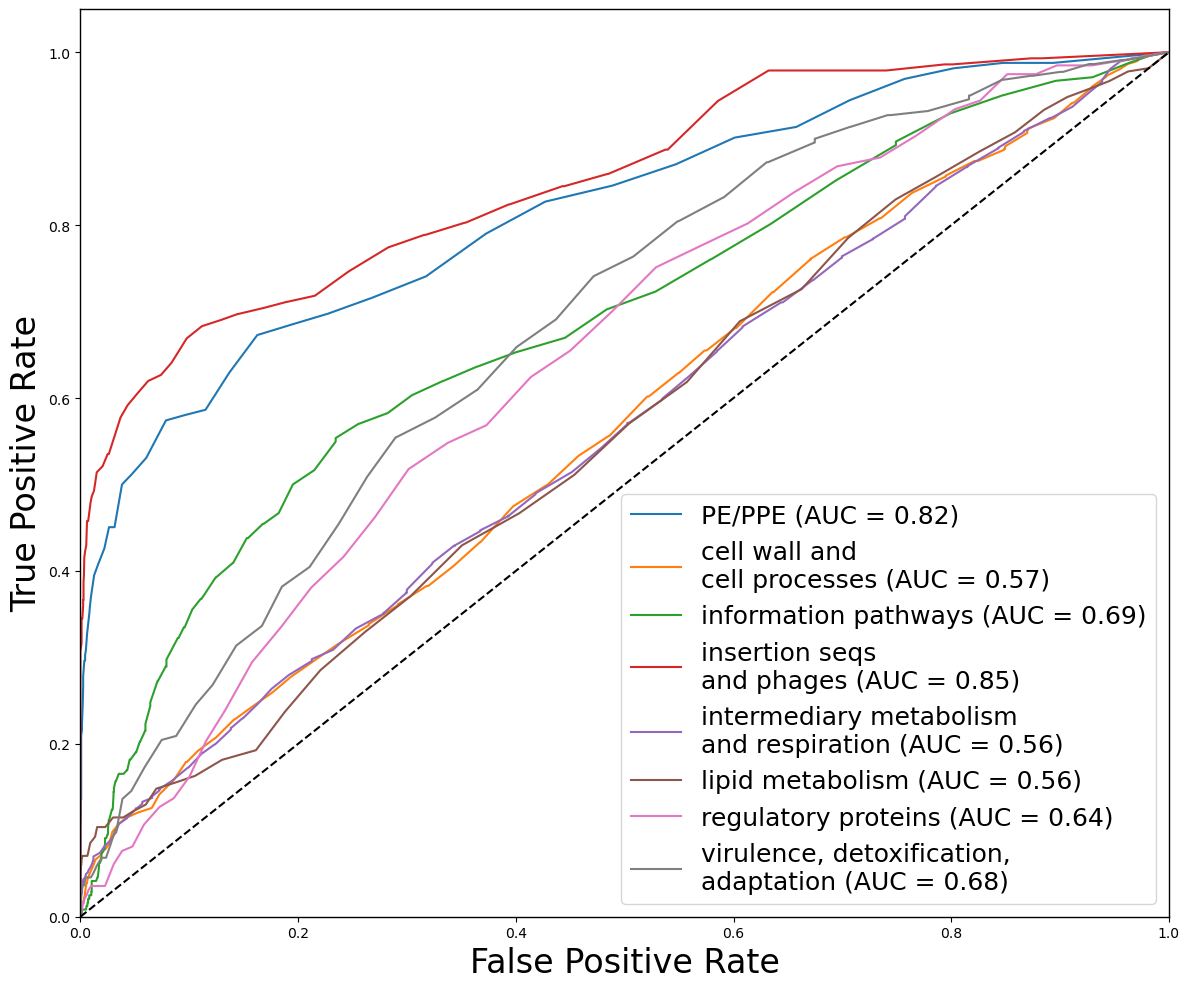

In [27]:
value_cols = [col for col in lfc_mb_filt.columns if col not in ['Rv_ID', 'Functional_Category']] 

lr_w_lasso_multilabel(lfc_mb_filt, value_cols, C=10, n_splits=5,
                norm_method='SMOTE', classifier='rf', name='Accuracy_log2FC_RF_Multilabel_SMOTE_C=10')

[0.20531154239019409, 0.21756894790602654, 0.24719101123595505]
Metrics for Logistic Regression with L1 Regularization:
F1 Macro: 0.2232
F1 Weighted: 0.2243
Cohen's Kappa: 0.1119
Macro AUROC: 0.5034



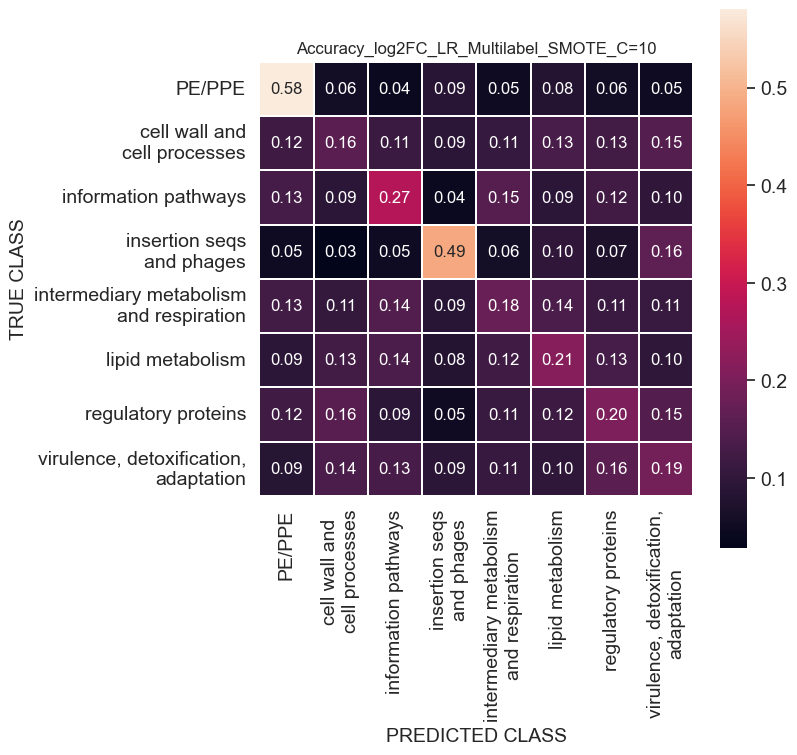

In [28]:
lasso_confusion(lfc_mb_filt, value_cols, C=10,
                norm_method='SMOTE', name='Accuracy_log2FC_LR_Multilabel_SMOTE_C=10')

[0.25842696629213485, 0.2604698672114402, 0.27579162410623087]
Metrics for Logistic Regression with L1 Regularization:
F1 Macro: 0.2363
F1 Weighted: 0.2683
Cohen's Kappa: 0.1203
Macro AUROC: 0.4979



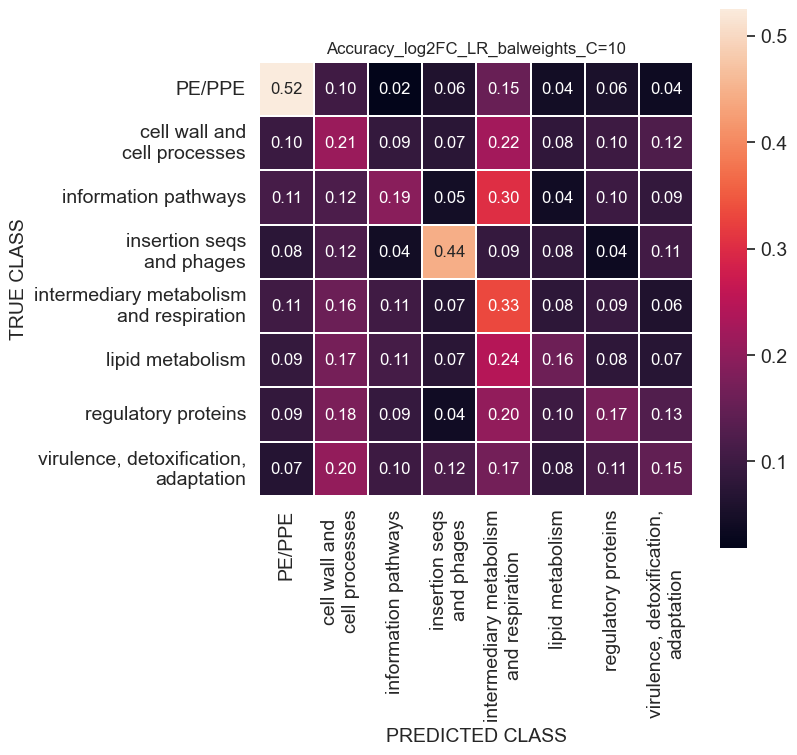

In [29]:
lasso_confusion(lfc_mb_filt, value_cols, C=10, norm_method='bal_weights',
                name='Accuracy_log2FC_LR_balweights_C=10')

[0.33401430030643514, 0.32175689479060265, 0.3391215526046987]
Metrics for Logistic Regression with L1 Regularization:
F1 Macro: 0.2405
F1 Weighted: 0.3011
Cohen's Kappa: 0.1154
Macro AUROC: 0.4983



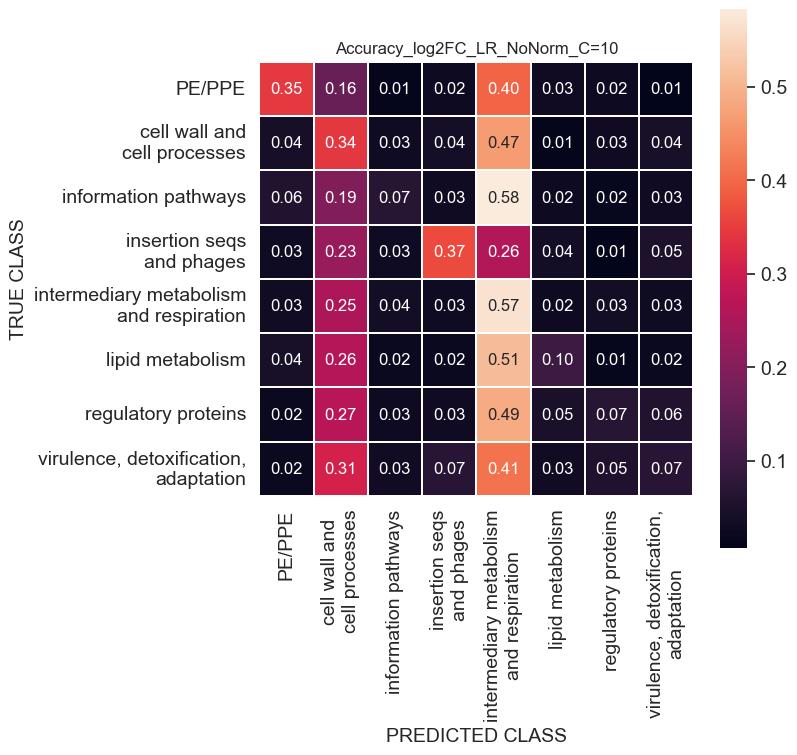

In [30]:
lasso_confusion(lfc_mb_filt, value_cols, C=10, norm_method=None,
                name='Accuracy_log2FC_LR_NoNorm_C=10')

In [31]:
lfc_mb_filt.Functional_Category.value_counts()

Functional_Category
intermediary metabolism and respiration    933
cell wall and cell processes               771
lipid metabolism                           270
information pathways                       242
virulence, detoxification, adaptation      220
regulatory proteins                        197
PE/PPE                                     162
insertion seqs and phages                  142
Name: count, dtype: int64

In [32]:
#lasso_coefs(lfc_mb_filt, value_cols, 10, 'SMOTE').to_csv('coefs_mb_lfc_SMOTE_C10.csv')

## With binary

In [33]:
#%reset -f

In [34]:
bin_mb_filt = pd.read_csv(
    '../../../data/standardized_data/cleaned_ML/bin_mb_filt.csv')

In [35]:
binary_data_cols = [col for col in bin_mb_filt.columns if col not in [
    'Rv_ID', 'Functional_Category']]

In [36]:
lasso_vanilla(bin_mb_filt, binary_data_cols, Cs=[0.005, 0.05, 0.1, 1, 10, 50])

{0.005: 0.2101947159690802, 0.05: 0.308378779399565, 0.1: 0.29886337997180773, 1: 0.28440914400358847, 10: 0.2714760257399346, 50: 0.2692781510689726}
Metrics for Logistic Regression Vanilla C=0.005:
F1 Macro: 0.1079
F1 Weighted: 0.0792
Cohen's Kappa: 0.0429
Macro AUROC: 0.4926

Metrics for Logistic Regression Vanilla C=0.05:
F1 Macro: 0.2262
F1 Weighted: 0.2131
Cohen's Kappa: 0.1267
Macro AUROC: 0.4996

Metrics for Logistic Regression Vanilla C=0.1:
F1 Macro: 0.2298
F1 Weighted: 0.2242
Cohen's Kappa: 0.1206
Macro AUROC: 0.5076

Metrics for Logistic Regression Vanilla C=1:
F1 Macro: 0.2215
F1 Weighted: 0.2201
Cohen's Kappa: 0.1101
Macro AUROC: 0.4975

Metrics for Logistic Regression Vanilla C=10:
F1 Macro: 0.2194
F1 Weighted: 0.2223
Cohen's Kappa: 0.1015
Macro AUROC: 0.4849

Metrics for Logistic Regression Vanilla C=50:
F1 Macro: 0.2181
F1 Weighted: 0.2216
Cohen's Kappa: 0.1009
Macro AUROC: 0.4869



[0.22778345250255363, 0.2247191011235955, 0.21144024514811033]
Metrics for Logistic Regression with L1 Regularization:
F1 Macro: 0.2189
F1 Weighted: 0.2255
Cohen's Kappa: 0.1050
Macro AUROC: 0.5042



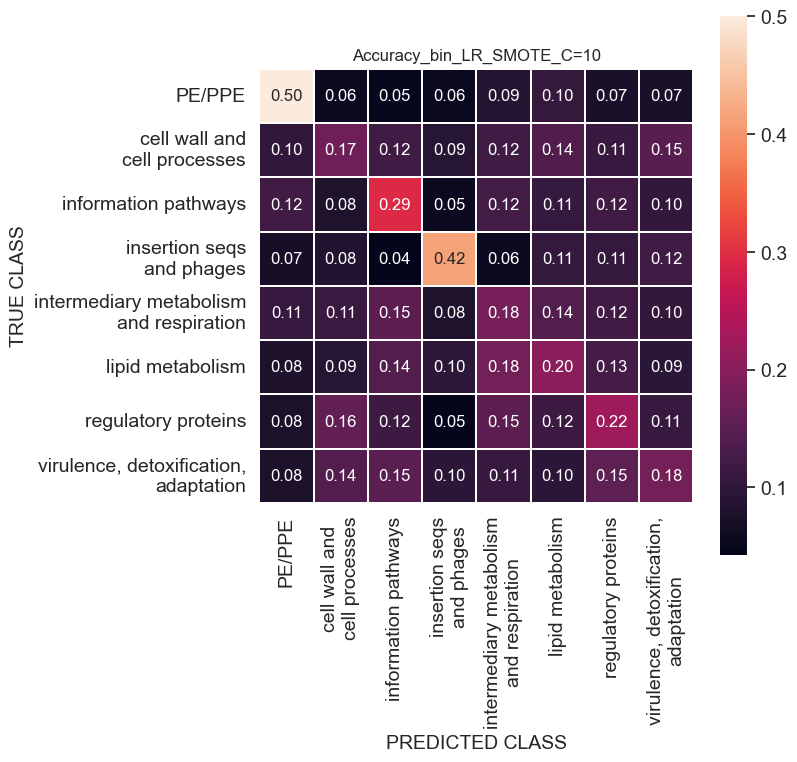

In [37]:
lasso_confusion(bin_mb_filt, binary_data_cols, C=10,
                norm_method='SMOTE', name='Accuracy_bin_LR_SMOTE_C=10')

[0.26149131767109296, 0.2727272727272727, 0.24923391215526047]
Metrics for Logistic Regression with L1 Regularization:
F1 Macro: 0.2352
F1 Weighted: 0.2662
Cohen's Kappa: 0.1156
Macro AUROC: 0.5023



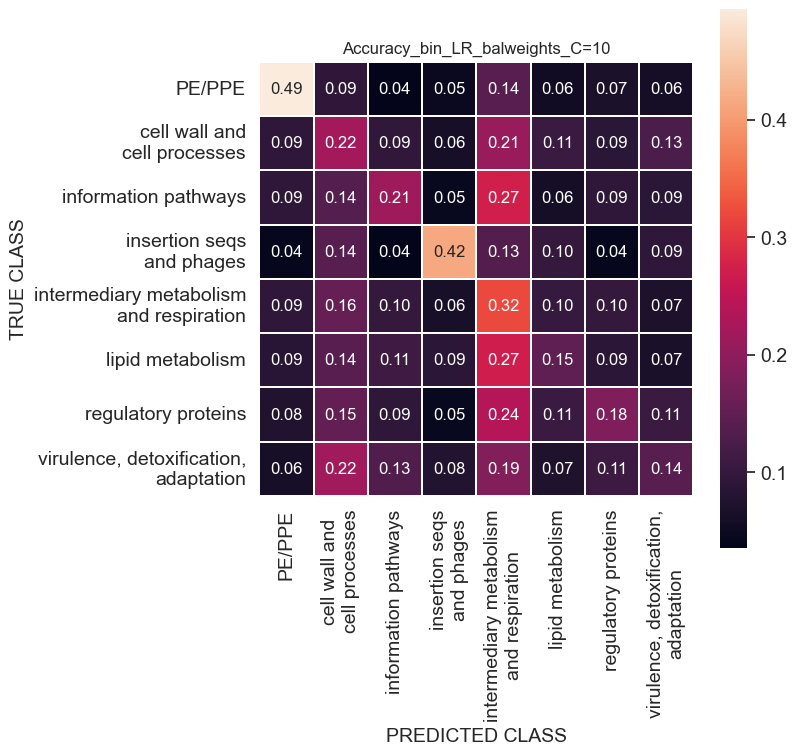

In [38]:
lasso_confusion(bin_mb_filt, binary_data_cols, C=10,
                norm_method='bal_weights', name='Accuracy_bin_LR_balweights_C=10')

## With log2FC and binary

In [39]:
#%reset -f

In [50]:
lfc_mb_filt = pd.read_csv(
    '../../../data/standardized_data/cleaned_ML/lfc_mb_filt_07_22_24.csv')
bin_mb_filt = pd.read_csv(
    '../../../data/standardized_data/cleaned_ML/bin_mb_filt.csv')
assert (lfc_mb_filt.columns.sort_values() == bin_mb_filt.columns.sort_values()).all()
#assert (lfc_mb_filt.columns == bin_mb_filt.columns).all()

ValueError: Lengths must match to compare

In [ ]:
value_cols = [col for col in lfc_mb_filt.columns if col not in [
    'Rv_ID', 'Functional_Category']]

In [ ]:
bin_mb_filt = bin_mb_filt.rename(
    columns={col: col + '_bin' for col in value_cols})

In [ ]:
lfc_bin_mb = pd.merge(lfc_mb_filt, bin_mb_filt, how='left', on='Rv_ID').rename(columns={
    'Functional_Category_y': 'Functional_Category'}).drop(columns=['Functional_Category_x'])

In [ ]:
lfc_bin_mb.to_csv(
    '../../../data/standardized_data/cleaned_ML/bin_mb_filt.csv', index=False)

In [ ]:
lfc_bin_cols = [col for col in lfc_bin_mb.columns if col not in [
    'Rv_ID', 'Functional_Category']]

In [ ]:
lasso_vanilla(lfc_bin_mb, lfc_bin_cols, Cs=[0.005, 0.05, 0.1, 1, 10, 50])

In [ ]:
lasso_confusion(lfc_bin_mb, lfc_bin_cols, C=10,
                norm_method='SMOTE', name='Accuracy_lfc_bin_LR_SMOTE_C=10')

# umap with log2fc

In [ ]:
#%reset -f

In [41]:
umap_10 = pd.read_csv('../../../data/df_umap_10.csv')
umap = pd.read_csv('../../../data/df_umap.csv')

In [42]:
umap.head()

,Rv_ID,gene_name,Annotation,func_tuberculist,COG,u1,u2,cluster_labels
0,Rv0003,recF,2.0,information pathways,L,-17.735023,14.495029,15
1,Rv0006,gyrA,5.0,information pathways,L,-27.707169,27.708073,10
2,Rv0007,-,1.0,cell wall and cell processes,S,-24.125223,27.623251,4
3,Rv0009,ppiA,4.0,information pathways,O,-17.274980,29.045324,18
4,Rv0012,-,1.0,cell wall and cell processes,S,-14.381042,29.086258,14


In [43]:
umap = umap.drop(columns=['gene_name', 'func_tuberculist', 'COG'])
umap_10 = umap_10.drop(columns=['gene_name', 'func_tuberculist', 'COG'])

In [44]:
lfc_mb_filt = pd.read_csv(
    '../../../data/standardized_data/cleaned_ML/lfc_mb_filt.csv')
lfc_mb_filt.head()

,Rv_ID,PE35_KO_vs_mbio_H37Rv,PPE68_KO_vs_mbio_H37Rv,Rv0950c_KO_vs_CB_WT,Rv0954_KO_vs_RJ_WT,Rv1096_KO_vs_CB_WT,Rv3005c_KO_day32_vs_dejesus_H37Rv_day32,Rv3594_KO_vs_Rubin_FLUTE_WT,Rv3684_KO_vs_CB_WT,Rv3717_KO_vs_Rubin_FLUTE_WT,...,BXD73_vs_in_vitro_H37Rv,BXD73b_vs_in_vitro_H37Rv,BXD77_vs_in_vitro_H37Rv,BXD79_vs_in_vitro_H37Rv,BXD9_vs_in_vitro_H37Rv,BXD90_vs_in_vitro_H37Rv,BXD93_vs_in_vitro_H37Rv,C57BL.6J_vs_in_vitro_H37Rv,DBA.2J_vs_in_vitro_H37Rv,Functional_Category
0,Rv0001,-0.41,0.01,0.00,0.00,0.00,3.12,-0.06,0.00,-0.06,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,information pathways
1,Rv0002,3.28,2.38,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.48,0.00,0.00,0.00,information pathways
2,Rv0003,-0.03,-0.08,0.03,-1.20,0.39,3.83,0.31,0.17,-0.62,...,0.97,-0.19,0.05,0.59,0.04,0.13,0.33,0.43,0.32,information pathways
3,Rv0005,-0.22,0.14,0.13,-0.08,0.27,-2.38,0.70,-0.71,-0.37,...,-0.30,-1.79,-1.34,-0.33,-1.84,-0.30,0.71,-0.27,-0.02,information pathways
4,Rv0006,0.53,0.37,-1.21,1.66,0.25,1.18,3.31,-0.10,-0.12,...,-1.10,-0.95,0.33,-0.20,-1.32,-0.35,-0.88,1.49,-1.31,information pathways


In [45]:
lfc_umap = lfc_mb_filt.merge(umap, how='left', on='Rv_ID')
lfc_umap_10 = lfc_mb_filt.merge(umap_10, how='left', on='Rv_ID')

In [46]:
lfc_umap.isna().sum()

Rv_ID                        0
PE35_KO_vs_mbio_H37Rv        0
PPE68_KO_vs_mbio_H37Rv       0
Rv0950c_KO_vs_CB_WT          0
Rv0954_KO_vs_RJ_WT           0
                          ... 
Functional_Category          0
Annotation                1620
u1                        1599
u2                        1599
cluster_labels            1599
Length: 152, dtype: int64

In [47]:
#fill empty umaps with zero
lfc_umap = lfc_umap.fillna(0)
lfc_umap_10 = lfc_umap.fillna(0)


[0.21836734693877552, 0.22982635342185903, 0.24719101123595505]
Metrics for Logistic Regression with L1 Regularization:
F1 Macro: 0.2315
F1 Weighted: 0.2334
Cohen's Kappa: 0.1212
Macro AUROC: 0.5093



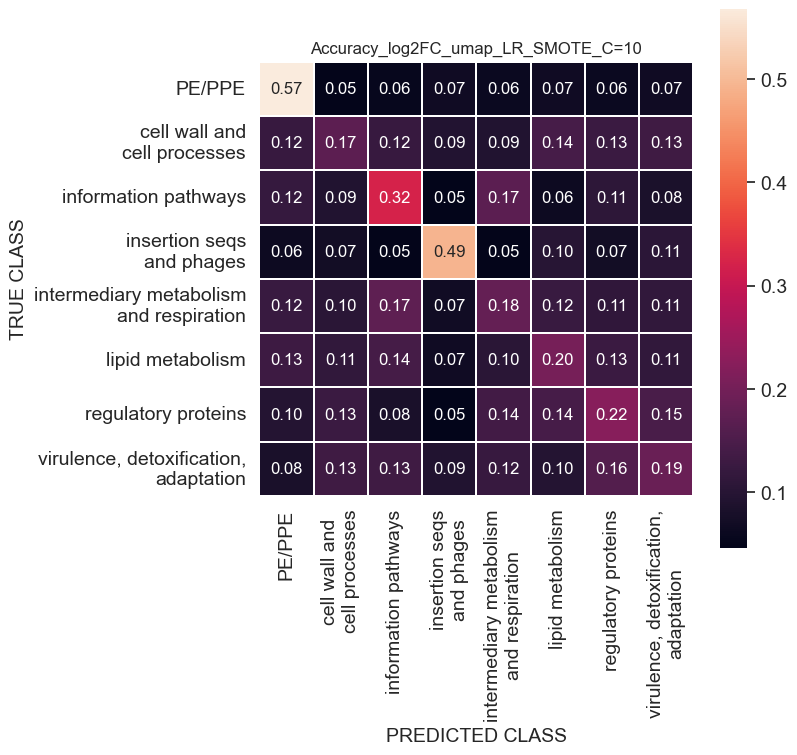

In [48]:
lfc_umap_value_cols = [col for col in lfc_umap.columns if col not in ['Rv_ID', 'Functional_Category']]
lasso_confusion(lfc_umap, lfc_umap_value_cols, C=10, norm_method='SMOTE',
                name='Accuracy_log2FC_umap_LR_SMOTE_C=10')

[0.22755102040816327, 0.22676200204290092, 0.22778345250255363]
Metrics for Logistic Regression with L1 Regularization:
F1 Macro: 0.2262
F1 Weighted: 0.2302
Cohen's Kappa: 0.1151
Macro AUROC: 0.5081



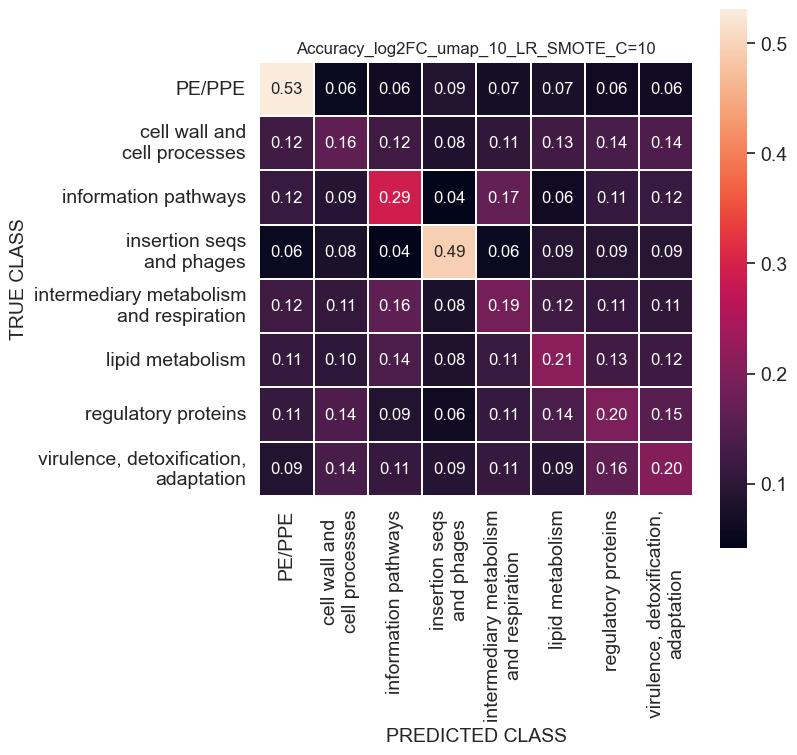

In [49]:
lfc_umap_10_value_cols = [col for col in lfc_umap_10.columns if col not in ['Rv_ID', 'Functional_Category']]
lasso_confusion(lfc_umap_10, lfc_umap_10_value_cols, C=10, norm_method='SMOTE',
                name='Accuracy_log2FC_umap_10_LR_SMOTE_C=10')